# Proyecto final: Breast Cancer Wisconsin (Original)

---
### Autores: Grupo 7
Raúl Murillo Montero - 5º Doble Grado en Ingeniería Informática - Matemáticas   
Miguel Sierra Esteso - 4º Grado en Ingeniería Informática


In [152]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
import sklearn.model_selection as ms
import scipy.optimize as opt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# import time

## Phase 1 - Data Exploration

In [2]:
#importing our cancer dataset
dataset = pd.read_csv('breast-cancer-wisconsin.csv')
print(dataset.shape)
dataset.head()

(699, 11)


,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### Missing or Null Data points

In [5]:
dataset.isin(['?']).sum()

id                    0
clump_thickness       0
size_uniformity       0
shape_uniformity      0
marginal_adhesion     0
epithelial_size       0
bare_nuclei          16
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                 0
dtype: int64

In [43]:
# Removing examples with missing data - can also be replaced by the feature mean (CHECK!)

missing = np.where(dataset['bare_nuclei'] == '?')[0]
dataset.drop(index = missing, inplace=True)
# Set numeric values to the feature
dataset['bare_nuclei'] = pd.to_numeric(dataset['bare_nuclei'])
dataset.shape

(683, 11)

<IPython.core.display.Javascript object>


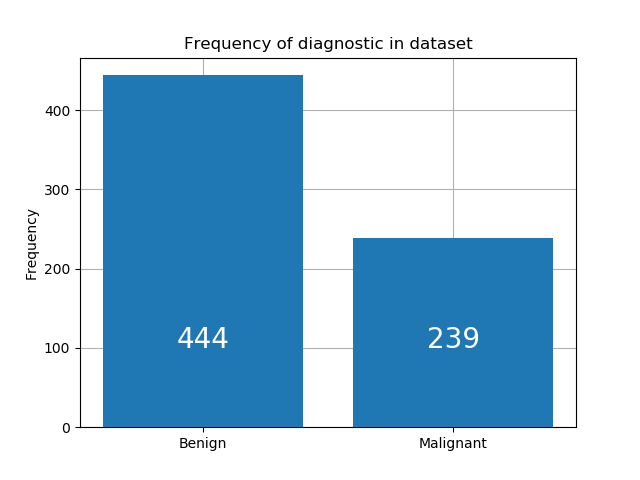

[444, 239]


In [142]:
Y = dataset['class'].values
plt.figure()
count = [sum(Y==2), sum(Y==4)]
plt.grid(zorder=0)
plt.bar(['Benign', 'Malignant'], count, zorder=3)
plt.title('Frequency of diagnostic in dataset')
plt.ylabel('Frequency')
plt.text(x=0, y=100, s=count[0], ha='center', color='w', fontsize=20)
plt.text(x=1, y=100, s=count[1], ha='center', color='w', fontsize=20)
plt.show()
# print(count)

### Data visualization

<IPython.core.display.Javascript object>


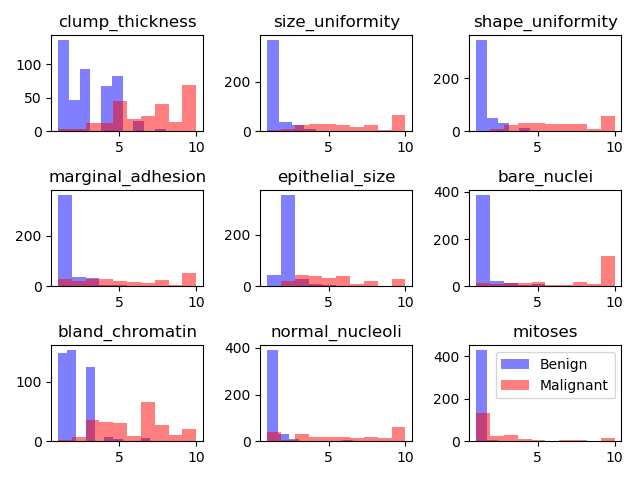

In [55]:
# For different diagnosis visual comparisons
# create two dataframes
neg_dataf = dataset[Y == 2]
pos_dataf = dataset[Y == 4]

features = list(dataset.columns[1:-1])

# Visualize all the features for positive and negative diagnoses
fig = plt.figure()

for i, f in enumerate(features):
    i +=1
    
    ax = fig.add_subplot(3, 3, i)
    
    # Plot corresponding histogram
    ax.hist(neg_dataf[f], label='Benign', stacked = True, alpha = 0.5, color = 'b')
    ax.hist(pos_dataf[f], label='Malignant', stacked = True, alpha = 0.5, color = 'r')
    ax.set_title(f)
    
    
plt.tight_layout()
plt.legend()
plt.show()

## Phase 2 - Data preprocessing


In [65]:
X = dataset[features].values

labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)

X.shape, Y.shape

((683, 9), (683,))

### Split data into training, validate and test sets

In [102]:
# Split data into train, validation and test sets - 60% 20% 20%
X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = ms.train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

### Normalize data

In [103]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Phase 3 - Model Selection

In [70]:
sigmoid = lambda x: 1 / (1 + np.e ** (-x))

### Logistic regression

In [125]:
J = lambda theta, x, y: -((np.log(sigmoid(x.dot(theta)))).T.dot(y) + (np.log(1 - sigmoid(x.dot(theta)))).T.dot(1 - y)) / len(y)

dJ = lambda theta, x, y: (x.T.dot(sigmoid(x.dot(theta)) - y)) / len(y)

Jreg = lambda theta, x, y, l: J(theta, x, y) + l / (2 * len(y)) * (np.square(theta[1:])).sum()

dJreg = lambda theta, x, y, l: dJ(theta, x, y) + l * np.hstack(([0], theta[1:])) / len(y)

In [126]:
# Use cross-validation method to find the best hyperparameter (learning rate)

X_train_ = np.c_[np.ones((len(X_train), 1)), X_train]
X_val_ = np.c_[np.ones((len(X_val), 1)), X_val]
theta = np.zeros(len(features) + 1)
costs = []

lr = np.arange(0, 2, 0.05)
for l in lr:
    result = opt.fmin_tnc(func=Jreg, x0=theta, fprime=dJreg, args=(X_train_, y_train, l) )
    theta_opt = result[0]
    costs.append(Jreg(theta_opt, X_val_, y_val, l))

# Get a prediction using the best hyperparameter
best_theta = opt.fmin_tnc(func=Jreg, x0=theta, fprime=dJreg, args=(X_train_, y_train, lr[np.argmin(costs)]))[0]
y_pred = sigmoid(np.c_[np.ones((len(X_test), 1)), X_test].dot(best_theta))
y_pred = (y_pred >= 0.5)*1

print(confusion_matrix(y_test, y_pred))

[[90  0]
 [ 2 45]]


#### Scikit learn version

In [156]:
clf = LogisticRegression(random_state=1, solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[90  0]
 [ 0 47]]


### Neural networks

### Support vector machines